In [1]:
import json
import os
import pickle
import random
import sys
import pickle

from typing import Callable, Dict, List, Optional
import haiku as hk
import ase
import ase.io
import jax
import jax.numpy as jnp
import numpy as np
import optax
import yaml

from phonax.datasets import (
    datasets,
    ph_datasets,
)
from phonax.optimizer import optimizer
from phonax.energy_force_train import energy_force_train
from phonax.loss import (
    WeightedEnergyFrocesStressLoss,
    HessianLoss,
)
from phonax.nequip_model import NequIP_JAXMD_model

from phonax.utils import (
    create_directory_with_random_name,
)

from phonax.phonons_train import (
    ph_evaluate,
    hessian_train,
    two_stage_hessian_train,
)

from phonax.predictors import (
    predict_energy_forces_stress,
    predict_hessian,
)
from phonax.phonons import (
    atoms_to_ext_graph, 
    predict_gamma_spectra_filter
)

from phonax.data_utils import to_f32

from phonax.trained_models import NequIP_JAXMD_molecule_model   

jax.config.update("jax_debug_nans", True)
jax.config.update("jax_debug_infs", True)
np.set_printoptions(precision=3, suppress=True)

# Introduction

Previously, we have been making the second derivative Hessian matrix predictions given an energy model, which is trained with zeroth and first order derivative data (i.e. energy and forces).
Here in this tutorial, we will demonstrate an alternative view of the Hessian data, and use them as part of the training data (the Hessian matrix, or the eigenvalue spectrum).

As discussed in our work, this augments the training dataset in converging the energy models. Locally, the second derivative data improves the local curvatures of the energy model landscape.
To demonstrate this here, we use molecular cases as the examples. There are two parts of this tutorial, the first one focuses on using the Hessian matrix as an extended data type to train the energy model/functional. The second part uses the eigenvalues of the Hessian matrix instead. The implications are the connections to the experimental probes for the vibrational modes such as IR / Raman / inelastic neutron scatterings.
This enables the energy model training or fine-tuning with realistic experimental data.

## Energy model training with molecular Hessian data

This section focuses on using the Hessian matrix as an extended data type to train the energy model/functional for the interatomic potentials.
The training procedure can be viewed as an extension to the conventional interatomic potential training using only the zeroth and first order training data for the energy landscape (i.e. energy and force).

For the specific example, we consdier the propane molecules as discussed in our work.
The structure of a propane molecule is mainly defined by the two torsion angles $\phi_1, \phi_2$ for the two C-C bonds.
Due to the symmetry, we only need to consider the range $[0,2\pi/3]$ for $\phi_i$.
In the valid dataset for the forces (in deriving the force MAE), we have scanned the $\phi_1, \phi_2$ angles ($31 \times 31$ grid). At each torsion angle combination, we also add a small Gaussian noise to the atomic coordinates.

In the training dataset, we only use four randomly generated propane structures (randomized torsion angles and perturbed atomic coordinates).
For the conventional training procedure, only the energy / force data is used, while the full molecular Hessians are added in the new training procedure to utilize the second order derivative information.
Below, we give more details for setting up these trainings.




### Initialize the training procedures

Here we load the training configurations and datasets, initialize the model, loss functions, and the predictors used for the next training steps.

In [2]:
# Load the config files
with open('data/propane/mol-propane.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
        
if 'save_dir_name' in config:
    save_dir_name = config['save_dir_name']
else:
    save_dir_name = create_directory_with_random_name()
print(save_dir_name)
        #os.path.splitext(os.path.basename(sys.argv[1]))[0]
        
# Save config and code
with open(f"{save_dir_name}/config.yaml", "w") as f:
    yaml.dump(config, f)
    
# Load the energy/force training/valid dataset
EF_train_loader, EF_valid_loader, EF_test_loader, EF_r_max = datasets(
    r_max = config["cutoff"],
    config_dataset = config["dataset"],
)
#print(len(EF_train_loader.graphs),len(EF_valid_loader.graphs))

# Load the Hessian training/valid dataset
ph_train_loader, ph_valid_loader, ph_test_loader, ph_r_max, num_message_passing = ph_datasets(
    r_max = config["cutoff"],
    config_dataset = config["ph_dataset"],
    num_message_passing = config['model']['num_layers'],
)
#print(len(ph_train_loader.graphs),len(ph_valid_loader.graphs))

assert ph_r_max==EF_r_max
r_max = EF_r_max

# Initialize the NequIP model
model_fn, params, num_message_passing = NequIP_JAXMD_model(
    r_max=r_max,
    atomic_energies_dict={},
    train_graphs=EF_train_loader.graphs,
    initialize_seed=config["model"]["seed"],
    num_species = config["model"]["num_species"],
    use_sc = True,
    graph_net_steps = config["model"]["num_layers"],
    hidden_irreps = config["model"]["internal_irreps"],
    nonlinearities =  {'e': 'swish', 'o': 'tanh'},
    save_dir_name = save_dir_name,
    reload = config["initialization"]['reload'] if 'reload' in config["initialization"] else None,
)
    
print("num_params:", sum(p.size for p in jax.tree_util.tree_leaves(params)))

# Define Loss functions for energy/force and Hessians
EF_loss_fn = WeightedEnergyFrocesStressLoss(
    energy_weight = config["training"]["energy_weight"],
    forces_weight = config["training"]["forces_weight"],
    stress_weight = config["training"]["stress_weight"],
)

H_loss_fn = HessianLoss()

# Predictors for the energy/force/stress and Hessians
EF_predictor = jax.jit(
    lambda w, g: predict_energy_forces_stress(lambda *x: model_fn(w, *x), g)
)

H_predictor = jax.jit(
    lambda w, g: predict_hessian(lambda *x: model_fn(w, *x), g)
)


2024-01-11-21:14-xenophobic-aridatha
2024-01-11-21:14-xenophobic-aridatha
nums check 256 2048 10
Loaded 40 training configurations from 'data/propane/propane_force_N4.xyz'
Loaded 9610 validation configurations from 'data/propane/propane_v2_mesh_PBE_force.xyz'
Total number of configurations: train=40, valid=9610, test=0


100%|████████████████████████████████████| 9610/9610 [00:00<00:00, 24722.09it/s]
0it [00:00, ?it/s]
Pad valid: 100%|███████████████████████████| 1000/1000 [00:03<00:00, 272.31it/s]


Total number of configurations: train=4356, valid=1000, test=0
Compute the average number of neighbors: 10.000
Do not normalize the radial basis (avg_r_min=None)
Computed average Atomic Energies using least squares: {1: -6.220972980547945, 6: -2.3328648677054784}
Create NequIP (JAX-MD version) with parameters {'use_sc': True, 'graph_net_steps': 2, 'hidden_irreps': '24x0e+24x0o+12x1e+12x1o+8x2e+8x2o', 'nonlinearities': {'e': 'swish', 'o': 'tanh'}, 'r_max': 5.0, 'avg_num_neighbors': 10.0, 'avg_r_min': None, 'num_species': 100, 'radial_basis': <function bessel_basis at 0x7fb719c41080>, 'radial_envelope': <function soft_envelope at 0x7fb719c40fe0>}
num_params: 105836


### Training with energy / force training data

In this section, we demonstrate the energy model training by using only the energy and force training data, as is done in the conventional interatomic potential model training procedure.
Note in this simple propane molecule example, we only use four molecular configurations in the training dataset.



In [3]:
# force only training

Fonly_params = params.copy()

gradient_transform, steps_per_interval, max_num_intervals = optimizer(
    lr = config["training"]["learning_rate"],
    max_num_intervals = config["training"]["max_num_intervals"],
    steps_per_interval = config["training"]["steps_per_interval"],
    # weight_decay = config["training"]["weight_decay"],
)
optimizer_state = gradient_transform.init(params)
print("optimizer num_params:", sum(p.size for p in jax.tree_util.tree_leaves(optimizer_state)))
    
train_out = energy_force_train(
    EF_predictor,
    Fonly_params,
    optimizer_state,
    EF_train_loader,
    EF_valid_loader,
    EF_test_loader,
    gradient_transform,
    EF_loss_fn,
    max_num_intervals,
    steps_per_interval,
    save_dir_name,
    ema_decay = config["training"]["ema_decay"],
    patience = config["training"]["patience"],
)



optimizer num_params: 317510
Started training


eval_train:   0%|                                         | 0/4 [00:00<?, ?it/s]

Compiled function `model` for args:
cache size: 1


eval_train: 100%|███████████████████████████| 4/4 [00:05<00:00,  1.35s/it, n=36]


Interval 0: eval_train: loss=44.3532, mae_e_per_atom=750.6 meV, mae_f=522.2 meV/Å, mae_s=0.8 meV/Å³


eval_valid: 100%|██████████████████▉| 1066/1068 [00:15<00:00, 68.81it/s, n=9603]

Compiled function `model` for args:
cache size: 2


eval_valid: 100%|███████████████████| 1068/1068 [00:20<00:00, 52.43it/s, n=9610]


Interval 0: eval_valid: loss=49.4872, mae_e_per_atom=754.2 meV, mae_f=550.4 meV/Å, mae_s=0.8 meV/Å³


Train interval 0:   2%|▏           | 10/500 [00:07<04:14,  1.92it/s, loss=3.499]

Compiled function `update_fn` for args:
Outout: loss= 39.634
Compilation time: 7.050s, cache size: 1
Compiled function `update_fn` for args:
Outout: loss= 35.488
Compilation time: 0.015s, cache size: 2


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 66.92it/s, n=36]


Interval 1: eval_train: loss=0.0677, mae_e_per_atom=0.3 meV, mae_f=24.0 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 68.53it/s, n=9610]


Interval 1: eval_valid: loss=1.0084, mae_e_per_atom=1.1 meV, mae_f=67.1 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 67.81it/s, n=36]


Interval 2: eval_train: loss=0.0389, mae_e_per_atom=0.6 meV, mae_f=18.5 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 68.32it/s, n=9610]


Interval 2: eval_valid: loss=1.0545, mae_e_per_atom=1.4 meV, mae_f=68.2 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 65.20it/s, n=36]


Interval 3: eval_train: loss=0.0249, mae_e_per_atom=0.7 meV, mae_f=15.1 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 68.15it/s, n=9610]


Interval 3: eval_valid: loss=1.0137, mae_e_per_atom=1.5 meV, mae_f=66.9 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 67.15it/s, n=36]


Interval 4: eval_train: loss=0.0136, mae_e_per_atom=0.8 meV, mae_f=11.3 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 67.95it/s, n=9610]


Interval 4: eval_valid: loss=0.9484, mae_e_per_atom=1.3 meV, mae_f=63.6 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 66.66it/s, n=36]


Interval 5: eval_train: loss=0.0079, mae_e_per_atom=0.7 meV, mae_f=8.6 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 67.82it/s, n=9610]


Interval 5: eval_valid: loss=0.8525, mae_e_per_atom=1.2 meV, mae_f=59.0 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 65.06it/s, n=36]


Interval 6: eval_train: loss=0.0051, mae_e_per_atom=0.5 meV, mae_f=6.8 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 67.84it/s, n=9610]


Interval 6: eval_valid: loss=0.7972, mae_e_per_atom=1.3 meV, mae_f=55.4 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 66.67it/s, n=36]


Interval 7: eval_train: loss=0.0036, mae_e_per_atom=0.3 meV, mae_f=5.7 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 67.73it/s, n=9610]


Interval 7: eval_valid: loss=0.7833, mae_e_per_atom=1.2 meV, mae_f=53.6 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 67.92it/s, n=36]


Interval 8: eval_train: loss=0.0028, mae_e_per_atom=0.3 meV, mae_f=5.0 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 67.94it/s, n=9610]


Interval 8: eval_valid: loss=0.7885, mae_e_per_atom=1.0 meV, mae_f=52.6 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 67.24it/s, n=36]


Interval 9: eval_train: loss=0.0023, mae_e_per_atom=0.3 meV, mae_f=4.4 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 67.66it/s, n=9610]


Interval 9: eval_valid: loss=0.8120, mae_e_per_atom=1.0 meV, mae_f=52.5 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 66.04it/s, n=36]


Interval 10: eval_train: loss=0.0019, mae_e_per_atom=0.2 meV, mae_f=4.0 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 67.43it/s, n=9610]


Interval 10: eval_valid: loss=0.8345, mae_e_per_atom=1.0 meV, mae_f=52.4 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 67.82it/s, n=36]


Interval 11: eval_train: loss=0.0016, mae_e_per_atom=0.1 meV, mae_f=3.7 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 68.92it/s, n=9610]


Interval 11: eval_valid: loss=0.8648, mae_e_per_atom=1.1 meV, mae_f=52.8 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 63.89it/s, n=36]


Interval 12: eval_train: loss=0.0014, mae_e_per_atom=0.1 meV, mae_f=3.4 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 69.02it/s, n=9610]


Interval 12: eval_valid: loss=0.9025, mae_e_per_atom=1.0 meV, mae_f=53.4 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 67.95it/s, n=36]


Interval 13: eval_train: loss=0.0012, mae_e_per_atom=0.2 meV, mae_f=3.2 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 69.02it/s, n=9610]


Interval 13: eval_valid: loss=0.9284, mae_e_per_atom=1.2 meV, mae_f=53.8 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 65.86it/s, n=36]


Interval 14: eval_train: loss=0.0011, mae_e_per_atom=0.1 meV, mae_f=3.0 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 69.05it/s, n=9610]


Interval 14: eval_valid: loss=0.9599, mae_e_per_atom=1.1 meV, mae_f=54.3 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 67.76it/s, n=36]


Interval 15: eval_train: loss=0.0009, mae_e_per_atom=0.2 meV, mae_f=2.8 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 68.55it/s, n=9610]


Interval 15: eval_valid: loss=0.9881, mae_e_per_atom=1.2 meV, mae_f=54.8 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 68.34it/s, n=36]


Interval 16: eval_train: loss=0.0008, mae_e_per_atom=0.2 meV, mae_f=2.6 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 68.27it/s, n=9610]


Interval 16: eval_valid: loss=1.0164, mae_e_per_atom=1.2 meV, mae_f=55.3 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 66.20it/s, n=36]


Interval 17: eval_train: loss=0.0007, mae_e_per_atom=0.1 meV, mae_f=2.5 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 69.14it/s, n=9610]


Interval 17: eval_valid: loss=1.0375, mae_e_per_atom=1.0 meV, mae_f=55.6 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 63.45it/s, n=36]


Interval 18: eval_train: loss=0.0007, mae_e_per_atom=0.1 meV, mae_f=2.4 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 68.53it/s, n=9610]


Interval 18: eval_valid: loss=1.0589, mae_e_per_atom=1.0 meV, mae_f=56.1 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 66.97it/s, n=36]


Interval 19: eval_train: loss=0.0006, mae_e_per_atom=0.2 meV, mae_f=2.2 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 68.68it/s, n=9610]


Interval 19: eval_valid: loss=1.0751, mae_e_per_atom=1.1 meV, mae_f=56.3 meV/Å, mae_s=1.4 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 65.39it/s, n=36]


Interval 20: eval_train: loss=0.0005, mae_e_per_atom=0.1 meV, mae_f=2.1 meV/Å, mae_s=1.2 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 68.39it/s, n=9610]


Interval 20: eval_valid: loss=1.0961, mae_e_per_atom=1.2 meV, mae_f=56.6 meV/Å, mae_s=1.4 meV/Å³
Training complete


### Training with molecular Hessians

In the next section, we show the energy model training with additional second order Hessian data beynd the force data at the first order derivative.
Specifically, there are two tages in the training procedure.
The first stage, or the warm-up stage, uses only the energy and force data to initialize the energy model training.
After trained with several warm-up steps, the second training stage adds the Hessian data in computing the loss function.
At the second stage, the update gradients come from both the energy / force training losses, and the Hessian losses, and we combine the two (weighted sum) to get the overall training gradient.

From the training results below, one can see the valid force MAE further decreases once we have included the Hessian training data in the second stage.

We note that, it remains an open question to find the optimal training procedure in adding the second order Hessian data. For example, one can perform the training without warm-up steps, or gradually ramp up the training weights associated with the Hessian losses.
It would be relevant to examine the energy model converged for their predictions and stability under molecular dynamics simulations.


In [3]:
FH_params = params.copy()

# restart the optimizer state
gradient_transform, steps_per_interval, max_num_intervals = optimizer(
    lr = config["training"]["learning_rate"],
    max_num_intervals = config["training"]["max_num_intervals"],
    steps_per_interval = config["training"]["steps_per_interval"],
    # weight_decay = config["training"]["weight_decay"],
)
optimizer_state = gradient_transform.init(params)
print("optimizer num_params:", sum(p.size for p in jax.tree_util.tree_leaves(optimizer_state)))

two_stage_hessian_train(
    energy_forces_stress_predictor=EF_predictor,
    phonon_predictor=H_predictor,
    params=FH_params,
    gradient_transform=gradient_transform,
    optimizer_state=optimizer_state,
    steps_per_interval=steps_per_interval,
    EF_loss_fn=EF_loss_fn,
    H_loss_fn=H_loss_fn,
    EF_train_loader=EF_train_loader,
    EF_valid_loader=EF_valid_loader,
    H_train_loader=ph_train_loader,
    H_valid_loader=ph_valid_loader,
    warmup_num_intervals=config['training']['warmup_num_intervals'],
    phtrain_num_intervals=config['training']['phtrain_num_intervals'],
)




optimizer num_params: 317510


eval_train:   0%|                                         | 0/4 [00:00<?, ?it/s]

Compiled function `model` for args:
cache size: 1


eval_train: 100%|███████████████████████████| 4/4 [00:05<00:00,  1.37s/it, n=36]


Interval 0: eval_train: loss=44.3532, mae_e_per_atom=750.565 meV, mae_f=522.178 meV/Å, mae_s=0.802 meV/Å³


eval_valid:  99%|██████████████████▉| 1061/1068 [00:15<00:00, 67.28it/s, n=9603]

Compiled function `model` for args:
cache size: 2


eval_valid: 100%|███████████████████| 1068/1068 [00:20<00:00, 51.81it/s, n=9610]
/home/shiangfang/miniconda3/envs/phonax/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shiangfang/miniconda3/envs/phonax/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Interval 0: eval_valid: loss=49.4872, mae_e_per_atom=754.195 meV, mae_f=550.353 meV/Å, mae_s=0.799 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 66.69it/s, n=36]


Interval 1: eval_train: loss=0.0678, mae_e_per_atom=0.289 meV, mae_f=24.034 meV/Å, mae_s=1.226 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 67.49it/s, n=9610]


Interval 1: eval_valid: loss=1.0080, mae_e_per_atom=1.182 meV, mae_f=67.117 meV/Å, mae_s=1.404 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 65.25it/s, n=36]


Interval 2: eval_train: loss=0.0389, mae_e_per_atom=0.588 meV, mae_f=18.516 meV/Å, mae_s=1.198 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 67.72it/s, n=9610]


Interval 2: eval_valid: loss=1.0539, mae_e_per_atom=1.356 meV, mae_f=68.166 meV/Å, mae_s=1.410 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 64.40it/s, n=36]


Interval 3: eval_train: loss=0.0248, mae_e_per_atom=0.674 meV, mae_f=15.119 meV/Å, mae_s=1.193 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 67.30it/s, n=9610]


Interval 3: eval_valid: loss=1.0134, mae_e_per_atom=1.485 meV, mae_f=66.930 meV/Å, mae_s=1.417 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 66.18it/s, n=36]


Interval 4: eval_train: loss=0.0135, mae_e_per_atom=0.788 meV, mae_f=11.331 meV/Å, mae_s=1.212 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 67.28it/s, n=9610]


Interval 4: eval_valid: loss=0.9512, mae_e_per_atom=1.365 meV, mae_f=63.675 meV/Å, mae_s=1.423 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 64.87it/s, n=36]


Interval 5: eval_train: loss=0.0079, mae_e_per_atom=0.644 meV, mae_f=8.594 meV/Å, mae_s=1.202 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 67.27it/s, n=9610]


Interval 5: eval_valid: loss=0.8542, mae_e_per_atom=1.302 meV, mae_f=59.068 meV/Å, mae_s=1.428 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 66.29it/s, n=36]


Interval 6: eval_train: loss=0.0051, mae_e_per_atom=0.463 meV, mae_f=6.796 meV/Å, mae_s=1.204 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 67.26it/s, n=9610]


Interval 6: eval_valid: loss=0.7981, mae_e_per_atom=1.298 meV, mae_f=55.446 meV/Å, mae_s=1.429 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 64.86it/s, n=36]


Interval 7: eval_train: loss=0.0037, mae_e_per_atom=0.341 meV, mae_f=5.736 meV/Å, mae_s=1.213 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 66.88it/s, n=9610]


Interval 7: eval_valid: loss=0.7852, mae_e_per_atom=1.171 meV, mae_f=53.699 meV/Å, mae_s=1.430 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 64.27it/s, n=36]


Interval 8: eval_train: loss=0.0028, mae_e_per_atom=0.269 meV, mae_f=5.025 meV/Å, mae_s=1.214 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 67.02it/s, n=9610]


Interval 8: eval_valid: loss=0.7903, mae_e_per_atom=1.104 meV, mae_f=52.668 meV/Å, mae_s=1.431 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 62.86it/s, n=36]


Interval 9: eval_train: loss=0.0022, mae_e_per_atom=0.223 meV, mae_f=4.422 meV/Å, mae_s=1.220 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 67.12it/s, n=9610]


Interval 9: eval_valid: loss=0.8143, mae_e_per_atom=1.123 meV, mae_f=52.510 meV/Å, mae_s=1.431 meV/Å³


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 64.30it/s, n=36]


Interval 0: eval_train: loss=0.0019, mae_e_per_atom=0.175 meV, mae_f=4.029 meV/Å, mae_s=1.208 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:15<00:00, 67.02it/s, n=9610]


Interval 0: eval_valid: loss=0.8359, mae_e_per_atom=1.090 meV, mae_f=52.501 meV/Å, mae_s=1.431 meV/Å³


Evaluating hessian train: 100%|█| 121/121 [00:06<00:00, 19.46it/s, n_graphs=4356


interval 0: hessian train hessian MAE 0.245 eV/A2 


Evaluating hessian valid: 100%|██| 28/28 [00:00<00:00, 81.14it/s, n_graphs=1000]


interval 0: hessian valid hessian MAE 0.237 eV/A2 


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 66.67it/s, n=36]


Interval 1: eval_train: loss=0.0178, mae_e_per_atom=0.453 meV, mae_f=11.894 meV/Å, mae_s=1.216 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:16<00:00, 65.63it/s, n=9610]


Interval 1: eval_valid: loss=0.1337, mae_e_per_atom=1.211 meV, mae_f=24.011 meV/Å, mae_s=1.455 meV/Å³


Evaluating hessian train: 100%|█| 121/121 [00:00<00:00, 145.00it/s, n_graphs=435


interval 1: hessian train hessian MAE 0.089 eV/A2 


Evaluating hessian valid: 100%|█| 28/28 [00:00<00:00, 149.45it/s, n_graphs=1000]


interval 1: hessian valid hessian MAE 0.082 eV/A2 


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 66.69it/s, n=36]


Interval 2: eval_train: loss=0.0120, mae_e_per_atom=0.486 meV, mae_f=10.137 meV/Å, mae_s=1.217 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:16<00:00, 66.41it/s, n=9610]


Interval 2: eval_valid: loss=0.0857, mae_e_per_atom=1.127 meV, mae_f=19.744 meV/Å, mae_s=1.464 meV/Å³


Evaluating hessian train: 100%|█| 121/121 [00:00<00:00, 148.58it/s, n_graphs=435


interval 2: hessian train hessian MAE 0.072 eV/A2 


Evaluating hessian valid: 100%|█| 28/28 [00:00<00:00, 150.35it/s, n_graphs=1000]


interval 2: hessian valid hessian MAE 0.067 eV/A2 


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 65.35it/s, n=36]


Interval 3: eval_train: loss=0.0095, mae_e_per_atom=0.827 meV, mae_f=9.045 meV/Å, mae_s=1.212 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:16<00:00, 66.54it/s, n=9610]


Interval 3: eval_valid: loss=0.0834, mae_e_per_atom=0.944 meV, mae_f=19.136 meV/Å, mae_s=1.463 meV/Å³


Evaluating hessian train: 100%|█| 121/121 [00:00<00:00, 145.46it/s, n_graphs=435


interval 3: hessian train hessian MAE 0.065 eV/A2 


Evaluating hessian valid: 100%|█| 28/28 [00:00<00:00, 148.37it/s, n_graphs=1000]


interval 3: hessian valid hessian MAE 0.058 eV/A2 


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 64.87it/s, n=36]


Interval 4: eval_train: loss=0.0078, mae_e_per_atom=0.376 meV, mae_f=8.265 meV/Å, mae_s=1.208 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:16<00:00, 65.54it/s, n=9610]


Interval 4: eval_valid: loss=0.0695, mae_e_per_atom=0.869 meV, mae_f=17.837 meV/Å, mae_s=1.465 meV/Å³


Evaluating hessian train: 100%|█| 121/121 [00:00<00:00, 147.54it/s, n_graphs=435


interval 4: hessian train hessian MAE 0.059 eV/A2 


Evaluating hessian valid: 100%|█| 28/28 [00:00<00:00, 150.55it/s, n_graphs=1000]


interval 4: hessian valid hessian MAE 0.051 eV/A2 


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 65.15it/s, n=36]


Interval 5: eval_train: loss=0.0063, mae_e_per_atom=0.323 meV, mae_f=7.471 meV/Å, mae_s=1.219 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:16<00:00, 66.03it/s, n=9610]


Interval 5: eval_valid: loss=0.0584, mae_e_per_atom=0.692 meV, mae_f=16.446 meV/Å, mae_s=1.469 meV/Å³


Evaluating hessian train: 100%|█| 121/121 [00:00<00:00, 147.20it/s, n_graphs=435


interval 5: hessian train hessian MAE 0.054 eV/A2 


Evaluating hessian valid: 100%|█| 28/28 [00:00<00:00, 151.47it/s, n_graphs=1000]


interval 5: hessian valid hessian MAE 0.048 eV/A2 


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 62.35it/s, n=36]


Interval 6: eval_train: loss=0.0056, mae_e_per_atom=0.414 meV, mae_f=7.032 meV/Å, mae_s=1.225 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:16<00:00, 65.97it/s, n=9610]


Interval 6: eval_valid: loss=0.0581, mae_e_per_atom=0.796 meV, mae_f=16.354 meV/Å, mae_s=1.469 meV/Å³


Evaluating hessian train: 100%|█| 121/121 [00:00<00:00, 146.07it/s, n_graphs=435


interval 6: hessian train hessian MAE 0.050 eV/A2 


Evaluating hessian valid: 100%|█| 28/28 [00:00<00:00, 150.46it/s, n_graphs=1000]


interval 6: hessian valid hessian MAE 0.046 eV/A2 


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 65.19it/s, n=36]


Interval 7: eval_train: loss=0.0051, mae_e_per_atom=0.269 meV, mae_f=6.784 meV/Å, mae_s=1.210 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:16<00:00, 65.84it/s, n=9610]


Interval 7: eval_valid: loss=0.0596, mae_e_per_atom=0.561 meV, mae_f=16.195 meV/Å, mae_s=1.469 meV/Å³


Evaluating hessian train: 100%|█| 121/121 [00:00<00:00, 148.64it/s, n_graphs=435


interval 7: hessian train hessian MAE 0.049 eV/A2 


Evaluating hessian valid: 100%|█| 28/28 [00:00<00:00, 150.32it/s, n_graphs=1000]


interval 7: hessian valid hessian MAE 0.043 eV/A2 


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 64.53it/s, n=36]


Interval 8: eval_train: loss=0.0046, mae_e_per_atom=0.228 meV, mae_f=6.429 meV/Å, mae_s=1.226 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:16<00:00, 65.63it/s, n=9610]


Interval 8: eval_valid: loss=0.0598, mae_e_per_atom=0.524 meV, mae_f=16.076 meV/Å, mae_s=1.470 meV/Å³


Evaluating hessian train: 100%|█| 121/121 [00:00<00:00, 146.68it/s, n_graphs=435


interval 8: hessian train hessian MAE 0.048 eV/A2 


Evaluating hessian valid: 100%|█| 28/28 [00:00<00:00, 153.00it/s, n_graphs=1000]


interval 8: hessian valid hessian MAE 0.043 eV/A2 


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 63.93it/s, n=36]


Interval 9: eval_train: loss=0.0044, mae_e_per_atom=0.443 meV, mae_f=6.279 meV/Å, mae_s=1.209 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:16<00:00, 65.58it/s, n=9610]


Interval 9: eval_valid: loss=0.0584, mae_e_per_atom=0.799 meV, mae_f=15.824 meV/Å, mae_s=1.470 meV/Å³


Evaluating hessian train: 100%|█| 121/121 [00:00<00:00, 148.50it/s, n_graphs=435


interval 9: hessian train hessian MAE 0.046 eV/A2 


Evaluating hessian valid: 100%|█| 28/28 [00:00<00:00, 150.27it/s, n_graphs=1000]


interval 9: hessian valid hessian MAE 0.040 eV/A2 


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 64.58it/s, n=36]


Interval 10: eval_train: loss=0.0042, mae_e_per_atom=0.223 meV, mae_f=6.129 meV/Å, mae_s=1.206 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:16<00:00, 65.63it/s, n=9610]


Interval 10: eval_valid: loss=0.0584, mae_e_per_atom=0.522 meV, mae_f=15.539 meV/Å, mae_s=1.470 meV/Å³


Evaluating hessian train: 100%|█| 121/121 [00:00<00:00, 147.54it/s, n_graphs=435


interval 10: hessian train hessian MAE 0.045 eV/A2 


Evaluating hessian valid: 100%|█| 28/28 [00:00<00:00, 149.69it/s, n_graphs=1000]


interval 10: hessian valid hessian MAE 0.040 eV/A2 


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 63.11it/s, n=36]


Interval 11: eval_train: loss=0.0042, mae_e_per_atom=0.192 meV, mae_f=6.115 meV/Å, mae_s=1.208 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:16<00:00, 65.46it/s, n=9610]


Interval 11: eval_valid: loss=0.0540, mae_e_per_atom=0.486 meV, mae_f=15.138 meV/Å, mae_s=1.471 meV/Å³


Evaluating hessian train: 100%|█| 121/121 [00:00<00:00, 144.92it/s, n_graphs=435


interval 11: hessian train hessian MAE 0.043 eV/A2 


Evaluating hessian valid: 100%|█| 28/28 [00:00<00:00, 148.84it/s, n_graphs=1000]


interval 11: hessian valid hessian MAE 0.038 eV/A2 


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 67.56it/s, n=36]


Interval 12: eval_train: loss=0.0036, mae_e_per_atom=0.229 meV, mae_f=5.592 meV/Å, mae_s=1.230 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:16<00:00, 65.42it/s, n=9610]


Interval 12: eval_valid: loss=0.0534, mae_e_per_atom=0.479 meV, mae_f=14.925 meV/Å, mae_s=1.470 meV/Å³


Evaluating hessian train: 100%|█| 121/121 [00:00<00:00, 145.08it/s, n_graphs=435


interval 12: hessian train hessian MAE 0.042 eV/A2 


Evaluating hessian valid: 100%|█| 28/28 [00:00<00:00, 147.38it/s, n_graphs=1000]


interval 12: hessian valid hessian MAE 0.036 eV/A2 


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 62.58it/s, n=36]


Interval 13: eval_train: loss=0.0037, mae_e_per_atom=0.294 meV, mae_f=5.690 meV/Å, mae_s=1.205 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:16<00:00, 65.54it/s, n=9610]


Interval 13: eval_valid: loss=0.0567, mae_e_per_atom=0.472 meV, mae_f=15.105 meV/Å, mae_s=1.471 meV/Å³


Evaluating hessian train: 100%|█| 121/121 [00:00<00:00, 148.11it/s, n_graphs=435


interval 13: hessian train hessian MAE 0.041 eV/A2 


Evaluating hessian valid: 100%|█| 28/28 [00:00<00:00, 147.91it/s, n_graphs=1000]


interval 13: hessian valid hessian MAE 0.037 eV/A2 


eval_train: 100%|███████████████████████████| 4/4 [00:00<00:00, 63.77it/s, n=36]


Interval 14: eval_train: loss=0.0036, mae_e_per_atom=0.220 meV, mae_f=5.612 meV/Å, mae_s=1.229 meV/Å³


eval_valid: 100%|███████████████████| 1068/1068 [00:16<00:00, 65.34it/s, n=9610]


Interval 14: eval_valid: loss=0.0514, mae_e_per_atom=0.462 meV, mae_f=14.522 meV/Å, mae_s=1.472 meV/Å³


Evaluating hessian train: 100%|█| 121/121 [00:00<00:00, 145.88it/s, n_graphs=435


interval 14: hessian train hessian MAE 0.040 eV/A2 


Evaluating hessian valid: 100%|█| 28/28 [00:00<00:00, 149.89it/s, n_graphs=1000]


interval 14: hessian valid hessian MAE 0.037 eV/A2 


Interval 14: 100%|███████████████| 500/500 [00:10<00:00, 48.39it/s, loss=0.0194]


# Energy model fine-tuning with Hessian spectrum data




Here in this section,

In [9]:
model_fn, params, num_message_passing, r_max = NequIP_JAXMD_molecule_model(os.path.join(os.getcwd(), 'trained-models'))

train_crystal = ase.io.read('data/molecules/benzene.vasp')
train_crystal.pbc=False
train_graph = atoms_to_ext_graph(train_crystal, r_max, num_message_passing=1)
train_graph = jax.tree_util.tree_map(to_f32, train_graph)

test_crystal1 = ase.io.read('data/molecules/toluene.vasp')
test_crystal1.pbc=False
test_graph1 = atoms_to_ext_graph(test_crystal1, r_max, num_message_passing=1)
test_graph1 = jax.tree_util.tree_map(to_f32, test_graph1)

test_crystal2 = ase.io.read('data/molecules/phenol.vasp')
test_crystal2.pbc=False
test_graph2 = atoms_to_ext_graph(test_crystal2, r_max, num_message_passing=1)
test_graph2 = jax.tree_util.tree_map(to_f32, test_graph2)

train_masses = ase.data.atomic_masses[train_graph.nodes.species][train_graph.nodes.mask_primitive]
test_masses1 = ase.data.atomic_masses[test_graph1.nodes.species][test_graph1.nodes.mask_primitive]
test_masses2 = ase.data.atomic_masses[test_graph2.nodes.species][test_graph2.nodes.mask_primitive]


def read_gamma_modes(fname):
    all_modes = []
    with open(fname,'r') as f:
        for line in f:
            if "Mode" in line:
                all_modes.append(float(line.strip().split(',')[-1].strip().split()[0]))
    all_modes = jnp.array(all_modes)
    return all_modes
benzene_gamma = read_gamma_modes('data/molecules/benzene_gamma')
toluene_gamma = read_gamma_modes('data/molecules/toluene_gamma')
phenol_gamma = read_gamma_modes('data/molecules/phenol_gamma')

def loss_fn_train(spectra_in):
    return jnp.mean(jnp.abs(spectra_in-benzene_gamma))
def loss_fn_test(spectra_in):
    return jnp.mean(jnp.abs(spectra_in-toluene_gamma))
def mae_spectra(pred_spectra,target_spectra):
    return jnp.mean(jnp.abs(pred_spectra-target_spectra))


import optax

gradient_transform = optax.adam(5E-5)

optimizer_state = gradient_transform.init(params)

spectra_predictor = jax.jit(
    lambda w: predict_gamma_spectra_filter(w,model_fn,train_graph,train_masses)  #predict_gamma_spectra(lambda *x: model_fn(w, *x), test_graph)
)

valid_modes_original1 = predict_gamma_spectra_filter(params,model_fn,test_graph1,test_masses1)
valid_modes_original2 = predict_gamma_spectra_filter(params,model_fn,test_graph2,test_masses2)

print(valid_modes_original1)
print(valid_modes_original2)


Create NequIP (JAX-MD version) with parameters {'use_sc': True, 'graph_net_steps': 2, 'hidden_irreps': '96x0e+ 96x0o  + 64x1e +64x1o +64x2e +64x2o', 'nonlinearities': {'e': 'swish', 'o': 'tanh'}, 'r_max': 5.0, 'avg_num_neighbors': 53.2808396682792, 'avg_r_min': None, 'num_species': 100, 'radial_basis': <function bessel_basis at 0x7fc675cb8f40>, 'radial_envelope': <function soft_envelope at 0x7fc675cb8ea0>}
[  27.241  124.733  185.288  272.313  296.006  432.863  508.388  591.262
  638.448  673.533  726.167  756.616  773.11   790.474  918.766  964.463
  989.697 1014.223 1054.913 1109.872 1128.433 1175.232 1261.061 1390.29
 1393.739 1409.089 1410.737 1489.265 1489.482 1559.595 1614.208 3003.036
 3066.553 3076.231 3116.929 3120.129 3133.57  3182.578 3195.179]
[  56.127  114.344  168.365  267.759  325.269  471.621  477.716  585.247
  637.507  674.73   730.066  741.727  755.256  790.084  846.058  898.071
 1006.948 1031.635 1084.506 1121.792 1161.519 1234.501 1366.707 1401.575
 1468.404 1523.

In [10]:
@jax.jit
def update_fn(
    params, optimizer_state
):
    loss, grad = jax.value_and_grad(
        lambda params: loss_fn_train(spectra_predictor(params))
    )(params)

    updates, optimizer_state = gradient_transform.update(
        grad, optimizer_state, params
    )
    params = optax.apply_updates(params, updates)
    return loss, params, optimizer_state

spectra_mae = []

for ind in range(500):
    train_modes = predict_gamma_spectra_filter(params,model_fn,train_graph,train_masses)
    valid_modes1 = predict_gamma_spectra_filter(params,model_fn,test_graph1,test_masses1)
    valid_modes2 = predict_gamma_spectra_filter(params,model_fn,test_graph2,test_masses2)
    
    train_mae = mae_spectra(train_modes,benzene_gamma)
    valid_mae1 = mae_spectra(valid_modes1,toluene_gamma)
    valid_mae2 = mae_spectra(valid_modes2,phenol_gamma)

    loss, params, optimizer_state = update_fn(params, optimizer_state)

    print(
        'Benzene spectra MAE: ', 
        train_mae,
        'Toluene spectra MAE: ',
        valid_mae1,
        'Phenol spectra MAE: ',
        valid_mae2,
    )
    spectra_mae.append([train_mae, valid_mae1, valid_mae2])


Benzene spectra MAE:  91.12171 Toluene spectra MAE:  74.20551 Phenol spectra MAE:  118.95801
Benzene spectra MAE:  88.059845 Toluene spectra MAE:  74.18919 Phenol spectra MAE:  117.76283
Benzene spectra MAE:  85.86708 Toluene spectra MAE:  72.87429 Phenol spectra MAE:  115.70694
Benzene spectra MAE:  83.41568 Toluene spectra MAE:  70.7665 Phenol spectra MAE:  113.41099
Benzene spectra MAE:  80.89757 Toluene spectra MAE:  68.3862 Phenol spectra MAE:  110.95591
Benzene spectra MAE:  78.78432 Toluene spectra MAE:  65.72682 Phenol spectra MAE:  108.42663
Benzene spectra MAE:  76.699165 Toluene spectra MAE:  63.42361 Phenol spectra MAE:  106.05086
Benzene spectra MAE:  74.64546 Toluene spectra MAE:  61.307156 Phenol spectra MAE:  103.73342
Benzene spectra MAE:  72.41833 Toluene spectra MAE:  59.640274 Phenol spectra MAE:  101.66294
Benzene spectra MAE:  70.27754 Toluene spectra MAE:  58.177433 Phenol spectra MAE:  99.57655
Benzene spectra MAE:  68.56174 Toluene spectra MAE:  56.83075 Phenol

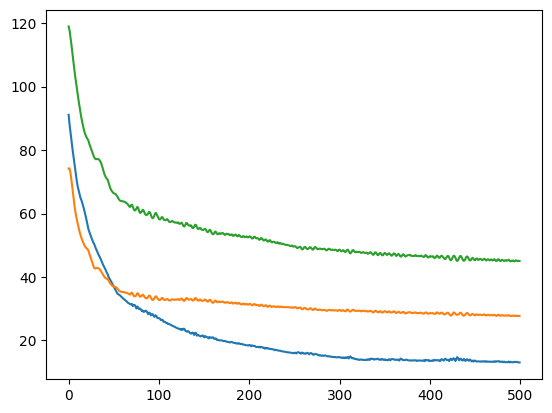

In [11]:
import matplotlib.pyplot as plt 
spectra_mae = np.array(spectra_mae)
plt.plot(spectra_mae)

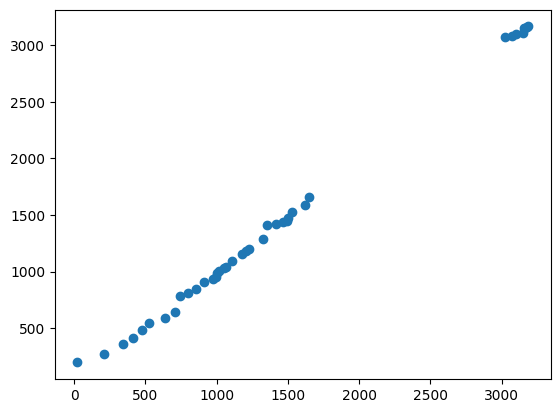

In [13]:
plt.scatter(toluene_gamma, valid_modes1)

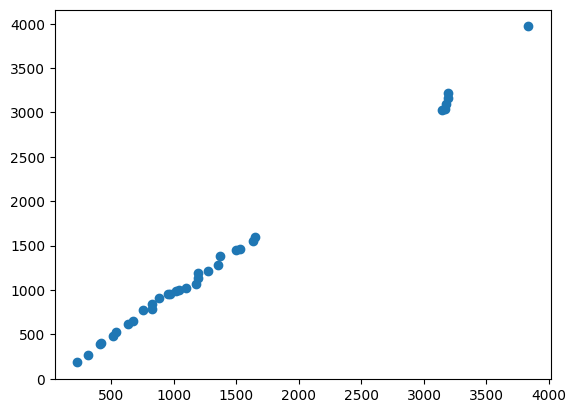

In [14]:
plt.scatter(phenol_gamma, valid_modes2)

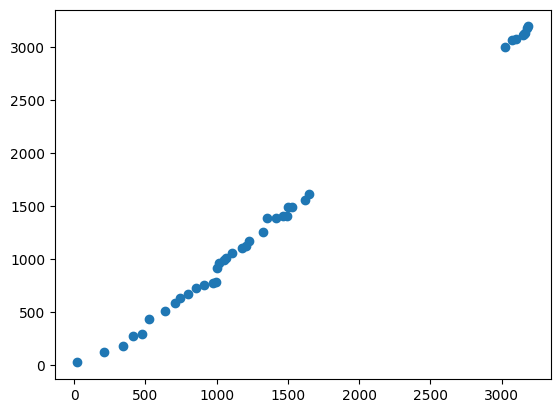

In [15]:

plt.scatter(toluene_gamma, valid_modes_original1)

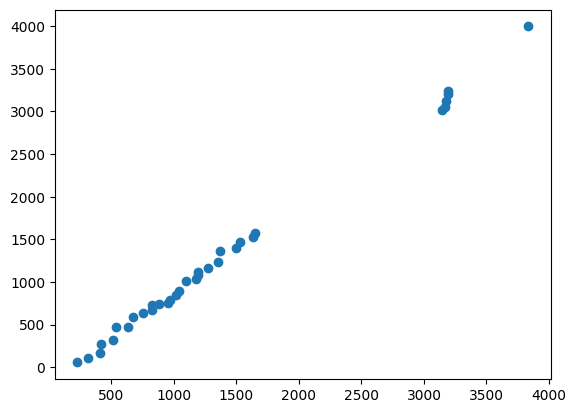

In [16]:
plt.scatter(phenol_gamma, valid_modes_original2)

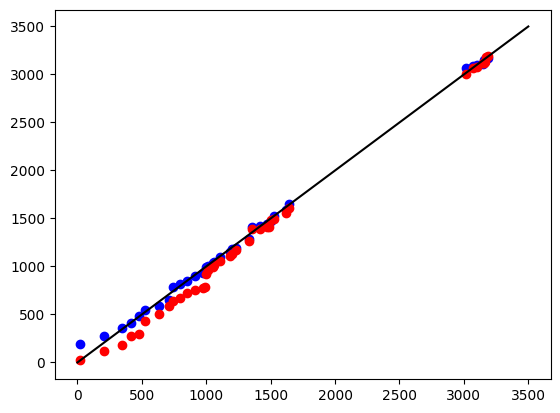

In [18]:
plt.scatter(toluene_gamma, valid_modes1, color='b')
plt.scatter(toluene_gamma, valid_modes_original1, color='r')
plt.plot([0,3500],[0,3500],color='k')

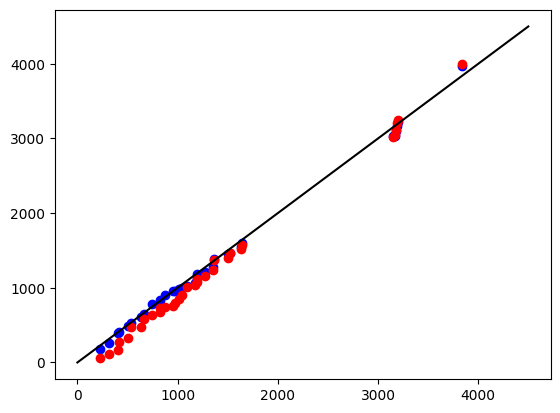

In [20]:
plt.scatter(phenol_gamma, valid_modes2, color='b')
plt.scatter(phenol_gamma, valid_modes_original2, color='r')
plt.plot([0,4500],[0,4500],color='k')

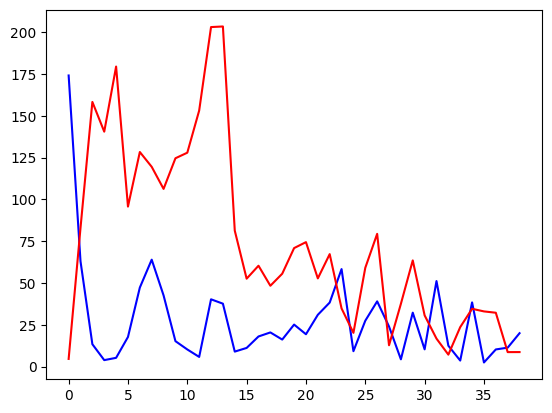

In [21]:
plt.plot(np.abs(-toluene_gamma+valid_modes1), color='b')
plt.plot(np.abs(-toluene_gamma+valid_modes_original1), color='r')

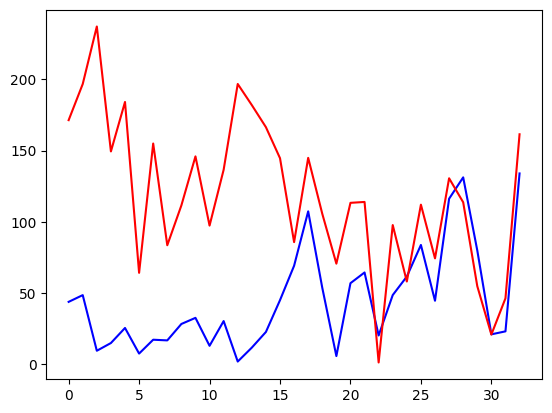

In [22]:
plt.plot(np.abs(-phenol_gamma+valid_modes2), color='b')
plt.plot(np.abs(-phenol_gamma+valid_modes_original2), color='r')

In [23]:
benzene_gamma

Array([ 409.748,  409.875,  622.161,  622.172,  686.588,  719.438,
        862.405,  862.419,  979.691,  979.726, 1010.604, 1011.054,
       1022.242, 1058.602, 1058.666, 1174.409, 1197.043, 1197.065,
       1335.573, 1380.654, 1509.93 , 1509.991, 1633.063, 1633.107,
       3154.428, 3164.629, 3164.645, 3180.355, 3180.37 , 3190.503],      dtype=float32)